In [34]:
!pip install camb
!pip install swyft==0.4.5
!pip install healpy

In [35]:
import camb
import matplotlib.pyplot as plt
import numpy as np
import torch
import swyft
import healpy as hp
from copy import deepcopy
#import os
green1='#238E68'
green2='#32CC99' 
green3='#76EEC6'
blue1='#00688B'
blue2='#0099CC'
blue3='#87CEEB'
orange1='#DD7500'
orange2='#FF9912'
orange3='#FFCC11'


In [36]:
!pip freeze | grep swyft

swyft==0.2.0


In [3]:
lmax=2500
fsky=0.6
ell=np.array([l for l in range(2,lmax+1)])
ells=ell*(ell+1)/(2*np.pi)

def generate_camb_cl(v = [67.5 , 0.022, 0.122, 0.06,  0.06, 3.05, 0.965]):
    """ Generate a temperature power spectrum given cosmological parameters"""
    V=np.around(v, decimals=6)
    H0 , ombh2, omch2, mnu, tau, logA, ns = V[0], V[1], V[2], V[3], V[4], V[5], V[6]
    As = 1e-10 * np.exp(logA)
    pars = camb.CAMBparams()
    try:
        pars.set_cosmology( H0 = H0, ombh2=ombh2, omch2=omch2, mnu=mnu, omk=0, tau=tau)
        pars.InitPower.set_params(As=As, ns=ns, r=0)
        pars.set_for_lmax(2500, lens_potential_accuracy=0);
        pars.NonLinear = camb.model.NonLinear_none
        results = camb.get_results(pars)
        powers = results.get_cmb_power_spectra(pars, CMB_unit='muK')
        totCL = powers['total']
        return totCL[:2499, 0]
    except:
        print('Failed simulation')
        return None
def noise(obs):
    nside = 1024
    cmb_map = hp.sphtfunc.synfast(obs, nside=nside)
    cl_hat = hp.sphtfunc.anafast(cmb_map)[:2499]
    return cl_hat


In [4]:
obs = generate_camb_cl()

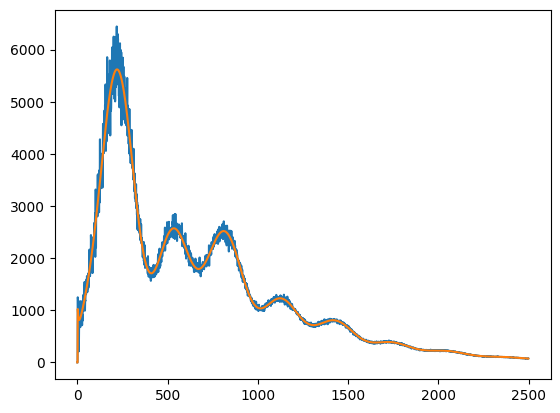

In [5]:
plt.plot(noise(obs))
plt.plot(obs)

In [6]:
def calc_cov_theory(cl):
    '''
    A function that calculates the covariance matrix
    Assumes that Cls are given for 2<l<2500
    
    Parameters
    ----------
    cl: ndarray or list 
        1D array or list of Cls 
        
    Returns
    -------
    A covariance matrix (NxN)
    '''
    lls = np.arange(2, 2499)
    return (np.diag(2 / (2 * lls + 1)  * cl[2:]**2))

In [7]:
covmat = calc_cov_theory(obs)

In [8]:
icovmat=np.linalg.inv(covmat)

In [9]:
pl = [67.5 , 0.022, 0.122, 0.06, 0.06, 3.05, 0.965]
def finiteD(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=generate_camb_cl(parr)[2:]
    m2=generate_camb_cl(parr2)[2:]
    output=(m1-m2)/(pl[k]*(2*eps))
    return output

In [10]:
ders=[finiteD(i) for i in range(7)]

In [11]:
F=np.zeros((7,7))
for i in range(7):
    for j in range(7):
        d1=ders[i]
        if i != j: 
            d2=ders[j]
        else: 
            d2=d1
        term1=np.dot(d1,np.matmul(icovmat,d2))
        F[i,j]=term1

In [12]:
Finv=np.linalg.inv(F)

In [13]:
def lnL(test, fid, cov_matrix = covmat):
    d_minus_mu = test - fid
    d_minus_mu_vector = [[i] for i in d_minus_mu ]
    e_factor = -0.5*np.matmul(np.transpose(d_minus_mu_vector), np.matmul(np.linalg.inv(cov_matrix), d_minus_mu_vector))
    factor = (np.sqrt(2*np.pi*np.linalg.norm(cov_matrix)))
    return e_factor - np.log(factor)

In [14]:
def finiteD2LNL(k, eps=1e-2):
    parr=list(pl)
    parr[k]=pl[k]*(1+eps)
    parr2=list(pl)
    parr2[k]=pl[k]*(1-eps)
    m1=generate_camb_cl(parr)[2:]
    m2=generate_camb_cl(parr2)[2:]
    m0=generate_camb_cl(pl)[2:]
    return (lnL(m0,m1)+lnL(m0,m2)-2*lnL(m0,m0))/(pl[k]*eps)**2

In [15]:
f00=finiteD2LNL(0)

In [16]:
print(-F[0][0]/f00)

[[0.99954414]]


In [17]:
sigss=[]
for i in range(7): sigss.append(np.sqrt(Finv[i,i]));

In [18]:
print (sigss)

[5.062667787957302, 9.223586360269198e-05, 0.0015434405569155487, 0.559832961330527, 0.0697485745370793, 0.1355332523130084, 0.0036735556092760734]


In [19]:
sigss = [5.062667787957302, 
         9.223586360269198e-05, 
         0.0015434405569155487, 
         0.559832961330527, 
         0.0697485745370793, 
         0.1355332523130084, 
         0.0036735556092760734]

In [20]:
def uv(u):
    offsets=np.array(pl)
    scales=np.array([5*sigss[i] for i in range(len(pl))])
    return 2*(u-0.5)*scales+offsets

In [21]:
print(uv(np.ones(7)))
print(uv(np.zeros(7)))

[9.28133389e+01 2.24611793e-02 1.29717203e-01 2.85916481e+00
 4.08742873e-01 3.72766626e+00 9.83367778e-01]
[ 4.21866611e+01  2.15388207e-02  1.14282797e-01 -2.73916481e+00
 -2.88742873e-01  2.37233374e+00  9.46632222e-01]


In [22]:
par_min = [4.21866611e+01 , 2.15388207e-02,  1.14282797e-01, -2.73916481e+00,
           -2.88742873e-01 , 2.37233374e+00 , 9.46632222e-01]
par_max = [9.28133389e+01 ,2.24611793e-02 ,1.29717203e-01, 2.85916481e+00,
           4.08742873e-01, 3.72766626e+00, 9.83367778e-01]

In [23]:
# Generate random numbers
random_params = np.random.uniform(par_min, par_max)

print(random_params)


[ 8.54748233e+01  2.16169632e-02  1.27216947e-01 -9.50687983e-01
 -2.76822054e-01  2.42923417e+00  9.65132545e-01]


In [33]:
sim=swyft.Simulator(generate_camb_cl, sim_shapes={'TT': [2495]}, pnames = ['H0' , 'ombh2', 'omch2', 
                                                                           'mnu', 'tau', 'logA', 'ns'])

AttributeError: module 'swyft' has no attribute 'Simulator'

In [31]:
store=swyft.DirectoryStore(path='demo-store.zarr', 
                           simulator=sim)

Creating new store.


In [33]:
from swyft.networks import OnlineNormalizationLayer
class HeadLinear(swyft.Module):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 10
        self.l = torch.nn.Linear(2495, 10)
        self.onl_f = OnlineNormalizationLayer(torch.Size([2495]))

    def forward(self, obs):
        x = torch.tensor(obs)
        x=self.onl_f(x)
        x = self.l(x)
        
        return x

In [34]:
partitions=[i for i in range(len(pl))]

In [38]:
task = swyft.Task(5000, prior, store, simhook = noise, bound=None)

AttributeError: module 'swyft' has no attribute 'Task'

**BELOW IS FOR NEW VERSION OF SWYFT**

In [105]:
obs_test = sim.sample(conditions = {'z': pl})
print(len(obs_test['x']))

2495


In [108]:
from swyft.networks import OnlineStandardizingLayer
class HeadLinear(swyft.SwyftModule):
    def __init__(self, obs_shapes):
        super().__init__(obs_shapes=obs_shapes)

        self.n_features = 10
        self.l = torch.nn.Linear(2495, 10)
        self.onl_f = OnlineStandardizingLayer(torch.Size([2495]))

    def forward(self, obs):
        x = torch.tensor(obs)
        x=self.onl_f(x)
        x = self.l(x)
        
        return x


In [109]:
partitions=[i for i in range(len(pl))]

AttributeError: module 'swyft' has no attribute 'SwyftTask'